# พลอตแผนที่ฝนรายชั่วโมงจากข้อมูลที่ดึงมาจากฝนสสน.รายชั่วโมง ของวันที่ต้องการ


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from shapely.geometry import Point
import glob
import os

%matplotlib inline 

## อ่านบางไฟล์เพื่อตรวจสอบ

In [2]:
## อ่านบางไฟล์เพื่อตรวจสอบ
# ก๊อปปี้แมนนวล '2Final_hourly_dates' เพื่อเอาไว้วิเคราะห์
file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071718.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(df.head())

# Get basic information about the dataframe
print(df.info())

   Unnamed: 0        date   time  rain station         full_date station_code  \
0           0  2018-07-17  18:00   0.0    BARI  2018-07-17-18:00         BARI   
1           1  2018-07-17  18:00   0.4    BDLH  2018-07-17-18:00         BDLH   
2           2  2018-07-17  18:00   0.0    BHMN  2018-07-17-18:00         BHMN   
3           3  2018-07-17  18:00   0.0    BKDN  2018-07-17-18:00         BKDN   
4           4  2018-07-17  18:00   0.2    BLUG  2018-07-17-18:00         BLUG   

             station_name   latitude   longitude     tambon          amphoe  \
0  ศูนย์อปพร. อบต.บ้านไร่  15.082674   99.519360    บ้านไร่         บ้านไร่   
1               ทต.ลานหอย  17.008568   99.582950     ลานหอย  บ้านด่านลานหอย   
2            อบต.ห้วยมุ่น  17.809134  100.939430   ห้วยมุ่น          น้ำปาด   
3              อบต.เขาทอง  15.570725  100.183205     เขาทอง       พยุหะคีรี   
4  สนามกีฬา อบต.ป่าคาหลวง  18.852882  100.434970  ป่าคาหลวง        บ้านหลวง   

    province      basin              s

## ทดสอบพลอตค่าฝนชั่วโมงที่สนใจ

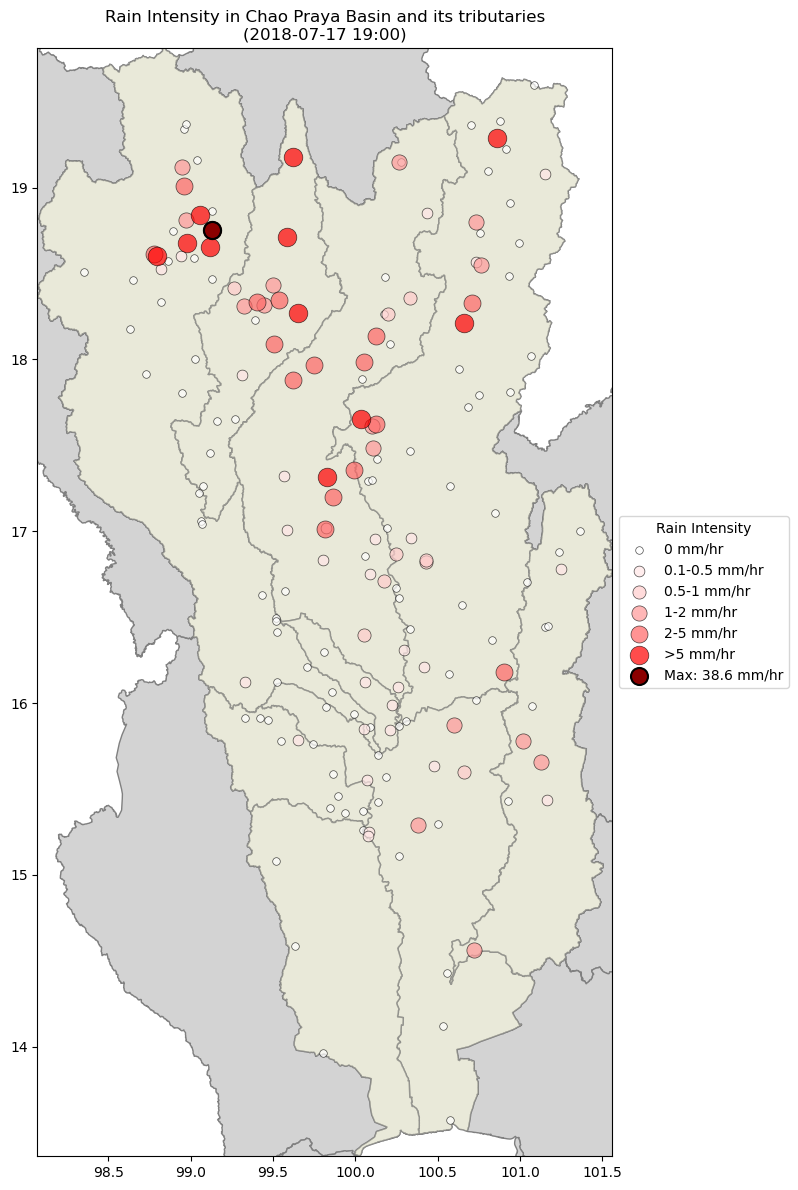

Total number of stations: 179
Stations with rainfall 0 mm/hr: 100
Stations with rainfall 0.1-0.5 mm/hr: 28
Stations with rainfall 0.5-1 mm/hr: 9
Stations with rainfall 1-2 mm/hr: 15
Stations with rainfall 2-5 mm/hr: 15
Stations with rainfall >5 mm/hr: 12
Station with max rainfall: รร.อนุบาล ทต.สันกำแพง (38.6 mm/hr)


In [3]:
'''
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
'''

# Read the shapefiles and CSV file
basin_map = gpd.read_file('../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_UTM47N.shp', encoding="UTF-8")
all_basin = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')
file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071718.csv'
df = pd.read_csv(file_path)

# Convert the dataframe to a GeoDataFrame
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
geo_df.set_crs(epsg=4326, inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the basins
basin_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=1)
all_basin.to_crs(epsg=4326).plot(ax=ax, color='lightyellow', edgecolor='grey', linewidth=1, alpha=0.5)

# Define rain intensity classes
rain_classes = [0, 0.1, 0.5, 1, 2, 5, np.inf]
colors = ['#FFFFFF', '#FFE6E6', '#FFCCCC', '#FF9999', '#FF6666', '#FF0000']
labels = ['0', '0.1-0.5', '0.5-1', '1-2', '2-5', '>5']

# Plot all stations
for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
    mask = (geo_df['rain'] >= lower) & (geo_df['rain'] < upper)
    ax.scatter(geo_df.loc[mask, 'longitude'], geo_df.loc[mask, 'latitude'], 
               c=colors[i], s=(i+1)*30, alpha=0.7, edgecolor='black', linewidth=0.5,
               label=f'{labels[i]} mm/hr')

# Highlight the station with the highest rainfall
max_rain_station = geo_df.loc[geo_df['rain'].idxmax()]
ax.scatter(max_rain_station['longitude'], max_rain_station['latitude'], 
           c='darkred', s=150, alpha=1, edgecolor='black', linewidth=1.5,
           label=f'Max: {max_rain_station["rain"]:.1f} mm/hr')

# Set the extent to focus on Chao Praya basin
ax.set_xlim(all_basin.total_bounds[0], all_basin.total_bounds[2])
ax.set_ylim(all_basin.total_bounds[1], all_basin.total_bounds[3])

# Add legend
ax.legend(title='Rain Intensity', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Rain Intensity in Chao Praya Basin and its tributaries\n(2018-07-17 19:00)')
plt.tight_layout()
plt.savefig('../3output/0map/rain_intensity_map_2018071719_red.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"Total number of stations: {len(geo_df)}")
for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
    count = ((geo_df['rain'] >= lower) & (geo_df['rain'] < upper)).sum()
    print(f"Stations with rainfall {labels[i]} mm/hr: {count}")
print(f"Station with max rainfall: {max_rain_station['station_name']} ({max_rain_station['rain']:.1f} mm/hr)")

# พลอตรายชั่วโมงในวันที่สนใจ

C:\Users\Admin\AppData\Local\Temp\ipykernel_19496\1386792381.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])


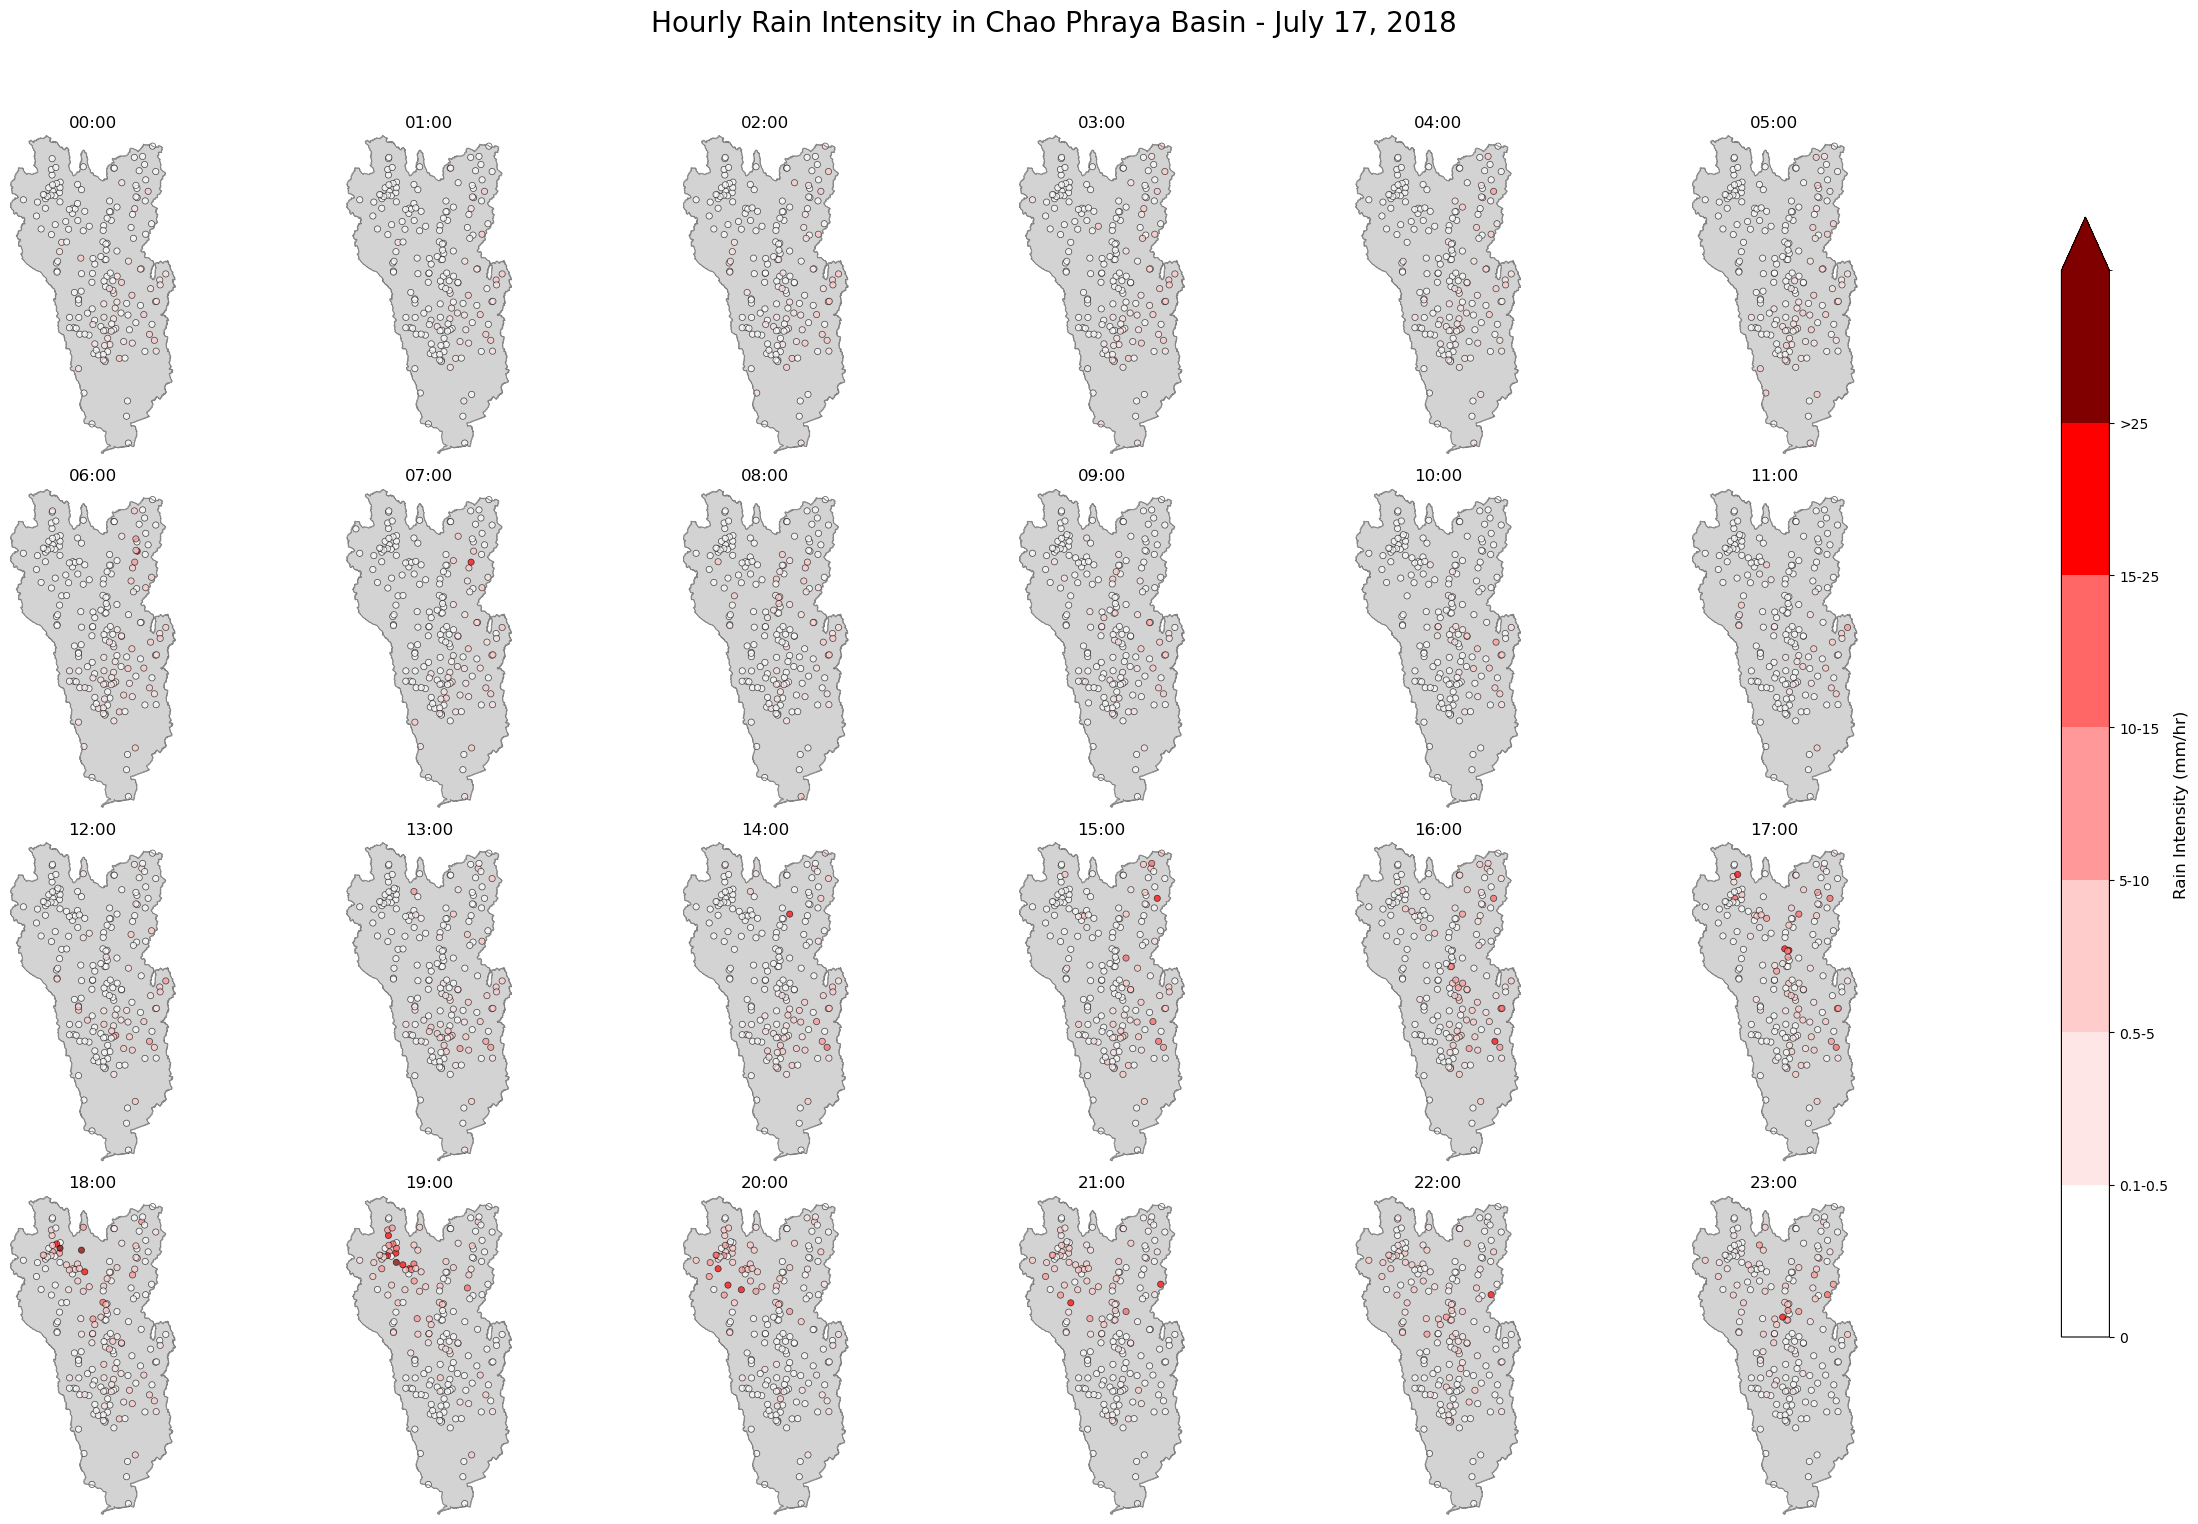


Total number of station readings: 4286
Readings with rainfall 0 mm/hr: 3038 (70.9%)
Readings with rainfall 0.1-0.5 mm/hr: 624 (14.6%)
Readings with rainfall 0.5-5 mm/hr: 507 (11.8%)
Readings with rainfall 5-10 mm/hr: 71 (1.7%)
Readings with rainfall 10-15 mm/hr: 21 (0.5%)
Readings with rainfall 15-25 mm/hr: 22 (0.5%)
Readings with rainfall >25 mm/hr: 3 (0.1%)
Maximum rainfall: 38.6 mm/hr at station รร.อนุบาล ทต.สันกำแพง at 2018-07-17-18:00


In [4]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
import glob
import os


# Read the shapefile for Chao Phraya basin
chao_phraya_basins = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_Boundary_WGS84Geo.shp')

# Ensure the CRS is set to EPSG:4326 (WGS84)
chao_phraya_basins = chao_phraya_basins.to_crs(epsg=4326)

# Check and fix the geometry if needed
chao_phraya_basins = chao_phraya_basins[chao_phraya_basins.geometry.is_valid]

# Dissolve all sub-basins into one shape
chao_phraya_outline = chao_phraya_basins.dissolve()

# Define rain intensity classes and colors
rain_classes = [0, 0.1, 0.5, 5, 10, 15, 25, 100]  # Changed upper bound to 100
colors = ['#FFFFFF', '#FFE6E6', '#FFCCCC', '#FF9999', '#FF6666', '#FF0000', '#800000']
labels = ['0', '0.1-0.5', '0.5-5', '5-10', '10-15', '15-25', '>25']
cmap = ListedColormap(colors)
norm = BoundaryNorm(rain_classes, cmap.N)

# Read all CSV files at once
directory = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/'
all_files = glob.glob(os.path.join(directory, '20180717*.csv'))
all_files.sort()

if not all_files:
    print("No data files found for July 17, 2018.")
    exit()

# Read all data into a single DataFrame and convert to GeoDataFrame
all_data = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
geo_df = gpd.GeoDataFrame(all_data, geometry=gpd.points_from_xy(all_data.longitude, all_data.latitude), crs="EPSG:4326")

# Create the 4x6 subplots
fig, axs = plt.subplots(4, 6, figsize=(24, 16))
fig.suptitle('Hourly Rain Intensity in Chao Phraya Basin - July 17, 2018', fontsize=20)

for hour in range(24):
    row, col = divmod(hour, 6)
    ax = axs[row, col]
    
    # Plot the outline of Chao Phraya basin
    chao_phraya_outline.boundary.plot(ax=ax, color='grey', linewidth=0.5)
    
    # Plot all sub-basins within Chao Phraya
    chao_phraya_basins.plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=0.5)
    
    # Filter data for this hour
    hour_data = geo_df[geo_df['time'] == f'{hour:02d}:00']
    
    if not hour_data.empty:
        scatter = ax.scatter(hour_data['longitude'], hour_data['latitude'], 
                             c=hour_data['rain'].clip(upper=100), cmap=cmap, norm=norm,
                             s=20, alpha=0.7, edgecolor='black', linewidth=0.5)
    else:
        ax.text(0.5, 0.5, f"No data for {hour:02d}:00", ha='center', va='center', transform=ax.transAxes)
    
    ax.set_title(f'{hour:02d}:00')
    ax.axis('off')
    
    # Set consistent limits for all subplots based on the Chao Phraya basins bounds
    bounds = chao_phraya_basins.total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

# Add a color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the colorbar to work correctly
cbar = fig.colorbar(sm, cax=cbar_ax, extend='max')
cbar.set_label('Rain Intensity (mm/hr)', fontsize=12)
cbar.set_ticks(rain_classes[:-1])
cbar.set_ticklabels(labels)

plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.savefig('../3output/0map/hourly_rain_intensity_grid_20180717_chao_phraya_subbasins_fixed.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print overall statistics
total_stations = len(geo_df)
print(f"\nTotal number of station readings: {total_stations}")
for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
    count = ((geo_df['rain'] >= lower) & (geo_df['rain'] < upper)).sum()
    print(f"Readings with rainfall {labels[i]} mm/hr: {count} ({count/total_stations*100:.1f}%)")
max_rain = geo_df['rain'].max()
max_rain_info = geo_df.loc[geo_df['rain'].idxmax()]
print(f"Maximum rainfall: {max_rain:.1f} mm/hr at station {max_rain_info['station_name']} at {max_rain_info['full_date']}")

# สิ่งที่ควรทำ
* ฝนสะสมรายวัน ให้ทำแบบนี้ 10 วัน เอา 5*2
* ทำกราฟฝนสะสมรายวัน

## ทดลองพลอตด้วยการประมาณค่าฝน IDW ก่อน

## ดูวิธีตามนี้
https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/Spatial-Interpolation/Inverse-Distance-Weighting/IDW-interpolation-of-weather-data/index.html
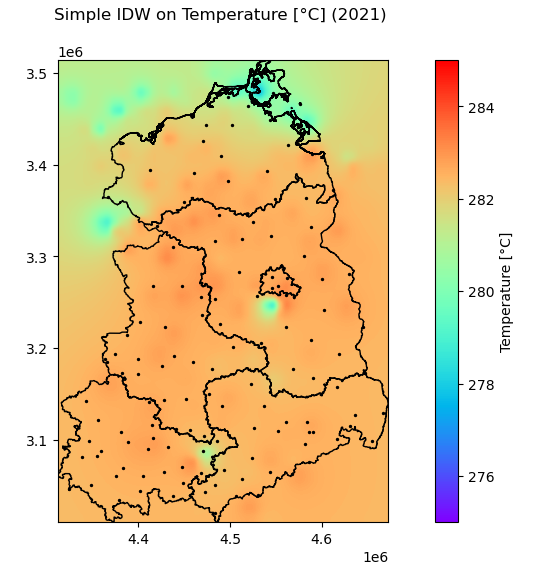

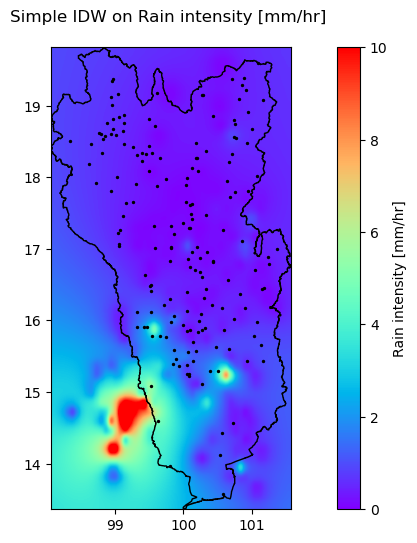

In [5]:
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
'''


# Read the shapefiles and CSV file
CPY_bnd = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_Boundary_WGS84Geo.shp')
CPY_bnd.set_crs(epsg=4326, inplace=True)

file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071719.csv'
df = pd.read_csv(file_path)
# Convert the dataframe to a GeoDataFrame
data_rain = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
data_rain.set_crs(epsg=4326, inplace=True)
'''
fig, ax = plt.subplots(figsize=(12, 6))
CPY_bnd.plot(ax=ax, color="none")
data_rain.plot(
    ax=ax,
    markersize=3.5,
    color="red",
)

plt.show()
'''

# Meshgrid for interpolation
xmin, ymin, xmax, ymax = CPY_bnd.total_bounds
# # size of the grid to interpolate
nx, ny = 50, 50

# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)
#plt.scatter(xi, yi, marker="o", color="none", edgecolor="grey", s=0.5)

# Interpolation of rain data using IDW
def distance_matrix(x0, y0, x1, y1):
    """
    Calculate distance matrix.
    Note: from <http://stackoverflow.com/questions/1871536>
    """

    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:, 0], interp[:, 0])
    d1 = np.subtract.outer(obs[:, 1], interp[:, 1])

    # calculate hypotenuse
    return np.hypot(d0, d1)


def simple_idw(x, y, z, xi, yi, beta=2):
    """
    Simple inverse distance weighted (IDW) interpolation
    x`, `y`,`z` = known data arrays containing coordinates and data used for interpolation
    `xi`, `yi` =  two arrays of grid coordinates
    `beta` = determines the degree to which the nearer point(s) are preferred over more distant points.
            Typically 1 or 2 (inverse or inverse squared relationship)
    """

    dist = distance_matrix(x, y, xi, yi)

    # In IDW, weights are 1 / distance
    # weights = 1.0/(dist+1e-12)**power
    weights = dist ** (-beta)

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)

# # size of the grid to interpolate
nx, ny = 50, 50

# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

'''
fig, ax = plt.subplots(figsize=(12, 6))
CPY_bnd.plot(ax=ax, color="none")
data_rain.plot(
    ax=ax,
    markersize=3.5,
    color="red",
)
ax.scatter(xi, yi, s=0.1)

plt.show()
'''

x = data_rain.geometry.x
y = data_rain.geometry.y
z = data_rain.rain
# Calculate IDW
rain_grid = simple_idw(x, y, z, xi, yi, beta=2)
rain_grid = rain_grid.reshape((nx, ny))
fig, ax = plt.subplots(figsize=(12, 6))

grid = ax.imshow(
    rain_grid,
    extent=(xmin, xmax, ymin, ymax),
    cmap="rainbow",
    interpolation="gaussian",
    vmin=0,
    vmax=10,
)
# plt.scatter(x,y,c=z, cmap='rainbow', edgecolors='black')
ax.scatter(x, y, color="black", s=2)
plt.title("Simple IDW on Rain intensity [mm/hr] \n")
CPY_bnd.plot(ax=ax, color="none")

fig.colorbar(grid, ax=ax, label="Rain intensity [mm/hr]")
plt.show()

* ผลลัพธ์ เหมือนมันกลับหัวกับข้อมูลฝนจริง

## try to flipud but it's not good ideas

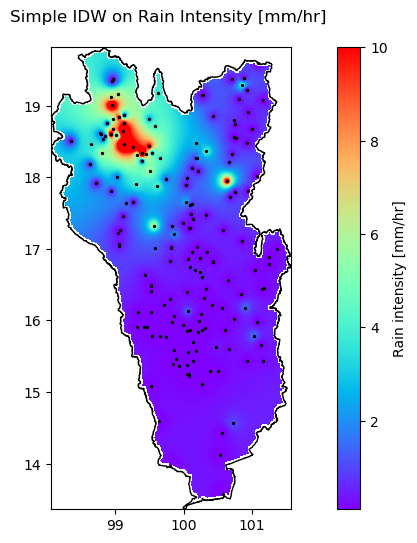

In [6]:
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
'''

# Read the shapefiles and CSV file
CPY_bnd = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_Boundary_WGS84Geo.shp')
CPY_bnd.set_crs(epsg=4326, inplace=True)

file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071719.csv'
df = pd.read_csv(file_path)

# Convert the dataframe to a GeoDataFrame
data_rain = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
data_rain.set_crs(epsg=4326, inplace=True)

# Meshgrid for interpolation
xmin, ymin, xmax, ymax = CPY_bnd.total_bounds
# Size of the grid to interpolate
nx, ny = 400, 400

# Generate two arrays of evenly spaced data between ends of previous arrays
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)

# Generate grid
xi, yi = np.meshgrid(xi, yi)
xi_flat, yi_flat = xi.flatten(), yi.flatten()

# Interpolation of rain data using IDW
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:, 0], interp[:, 0])
    d1 = np.subtract.outer(obs[:, 1], interp[:, 1])

    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, beta=2):
    dist = distance_matrix(x, y, xi, yi)
    weights = dist ** (-beta)
    weights /= weights.sum(axis=0)
    return np.dot(weights.T, z)

# Get x, y, z values from data
x = data_rain.geometry.x
y = data_rain.geometry.y
z = data_rain.rain

# Calculate IDW
rain_grid = simple_idw(x, y, z, xi_flat, yi_flat, beta=2)
rain_grid = rain_grid.reshape((nx, ny))

# Mask out areas with 0 mm rain
rain_grid = np.ma.masked_where(rain_grid == 0, rain_grid)

# Convert grid points to GeoDataFrame for clipping
grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xi_flat, yi_flat))
grid_points.set_crs(epsg=4326, inplace=True)

# Clip the grid points with the CPY_bnd boundary
clipped_grid = gpd.sjoin(grid_points, CPY_bnd, how="inner", predicate="within")

# Reshape the clipped grid back to 2D
clipped_rain_grid = np.ma.masked_all((ny, nx))
clipped_rain_grid[clipped_grid.index // nx, clipped_grid.index % nx] = rain_grid[clipped_grid.index // nx, clipped_grid.index % nx]



corrected_rain_grid = np.flipud(clipped_rain_grid)  # Flip the grid vertically  # เช็คตรงนี้ ว่าทำไมถึงต้องกลับหัวด้วย flipud แล้วหาก write เป็น geotif จะกลับหัวไหม
#corrected_rain_grid = np.fliplr(corrected_rain_grid)  # Uncomment if a horizontal flip is needed

# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))

# Show the corrected rain grid
grid = ax.imshow(
    corrected_rain_grid,
    extent=(xmin, xmax, ymin, ymax),
    cmap="rainbow",
    interpolation="gaussian",
    vmin=0.1,  # start at 0.1 to avoid showing 0 mm
    vmax=10,
)

# Overlay the stations
ax.scatter(data_rain.geometry.x, data_rain.geometry.y, color="black", s=2)

# Add the CPY_bnd boundary
CPY_bnd.plot(ax=ax, color="none", edgecolor="black")

# Add colorbar and title
fig.colorbar(grid, ax=ax, label="Rain intensity [mm/hr]")
plt.title("Simple IDW on Rain Intensity [mm/hr] \n")
plt.show()

# ลองทำให้ smooth ใน clade

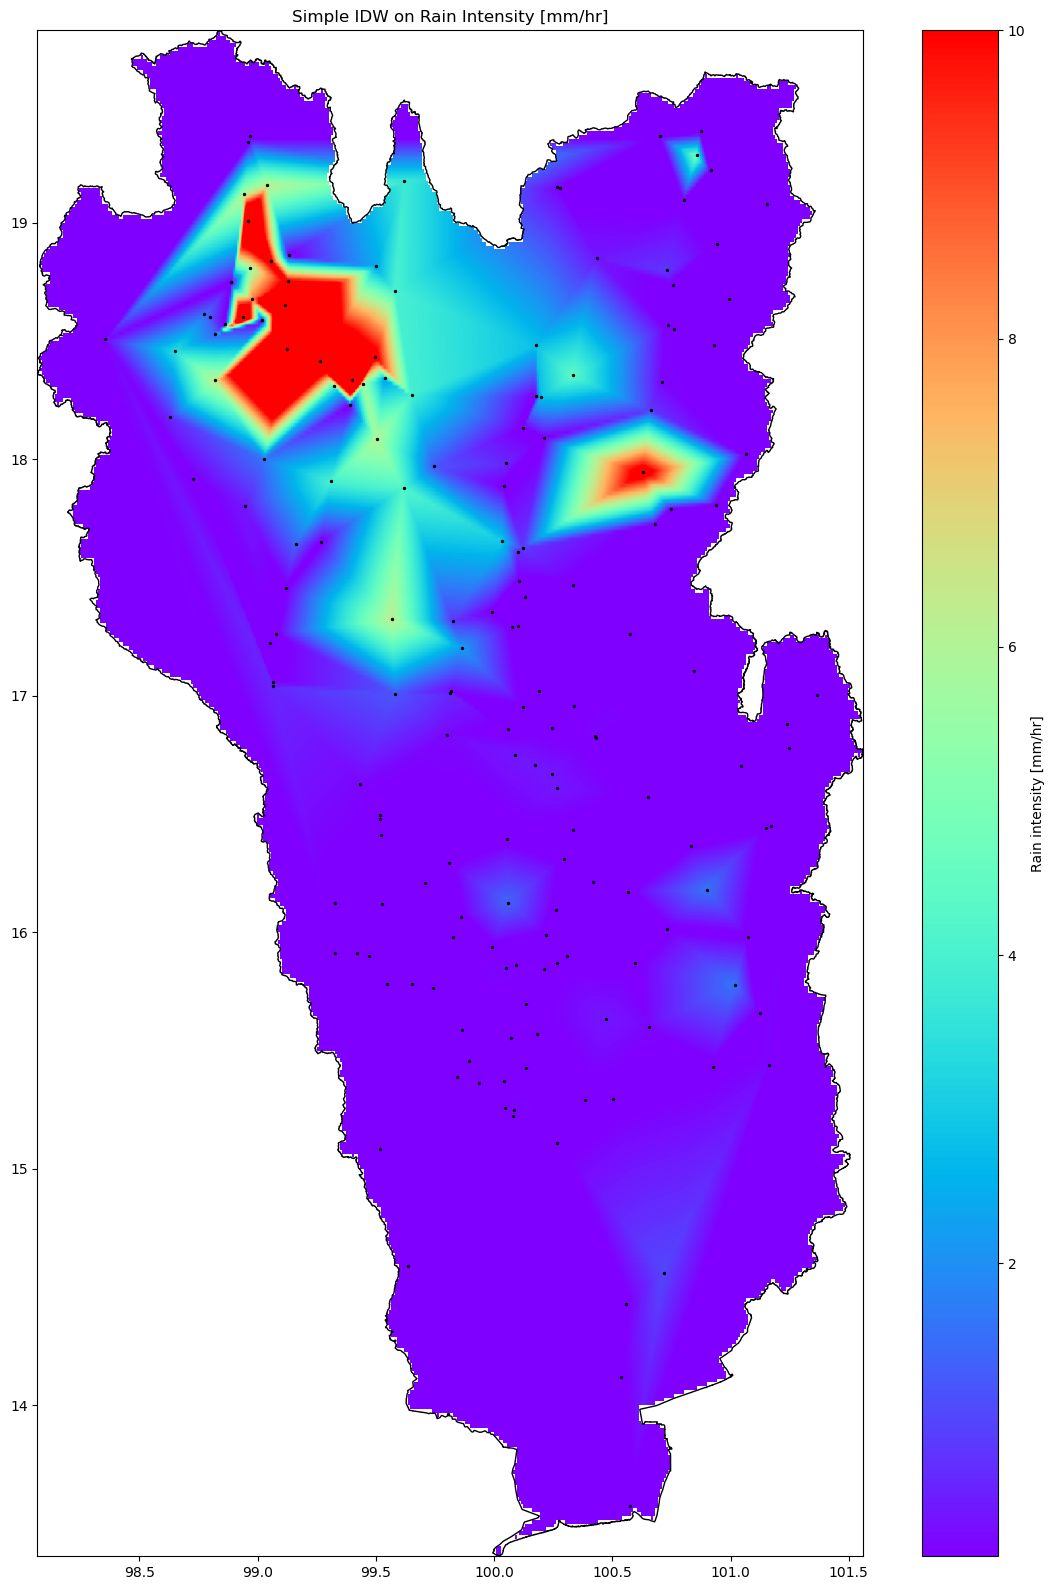

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import rasterio
from rasterio import features

# Read the data
CPY_bnd = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_Boundary_WGS84Geo.shp')
CPY_bnd.set_crs(epsg=4326, inplace=True)
file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071719.csv'
df = pd.read_csv(file_path)

# Convert the dataframe to a GeoDataFrame
data_rain = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
data_rain.set_crs(epsg=4326, inplace=True)

# Meshgrid for interpolation
xmin, ymin, xmax, ymax = CPY_bnd.total_bounds
nx, ny = 400, 400
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymax, ymin, ny)  # Note: ymax to ymin for correct orientation
xi, yi = np.meshgrid(xi, yi)

# Get x, y, z values from data
x = data_rain.geometry.x
y = data_rain.geometry.y
z = data_rain.rain

# Perform interpolation using griddata
rain_grid = griddata((x, y), z, (xi, yi), method='linear', fill_value=0)

# Create a mask for the Chao Phraya basin using rasterio
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, nx, ny)
mask = rasterio.features.geometry_mask([CPY_bnd.geometry.iloc[0]], out_shape=(ny, nx), transform=transform, invert=True)

# Apply the mask to the interpolated data
rain_grid_masked = np.where(mask, rain_grid, np.nan)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 16))

# Show the rain grid
im = ax.imshow(rain_grid_masked, extent=(xmin, xmax, ymin, ymax), 
               origin='upper', cmap='rainbow', vmin=0.1, vmax=10)

# Overlay the stations
ax.scatter(data_rain.geometry.x, data_rain.geometry.y, color="black", s=2)

# Add the CPY_bnd boundary
CPY_bnd.boundary.plot(ax=ax, color="black", linewidth=1)

# Add colorbar and title
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Rain intensity [mm/hr]")
plt.title("Simple IDW on Rain Intensity [mm/hr]")

# Adjust the aspect ratio to match the geographic coordinates
ax.set_aspect('equal')

# Set the correct y-axis direction
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

* ผลลัพธ์เหมือนทิศทางถูกต้อง เมื่อเทียบกับฝนแบบจุดที่พลอตในแผนที่ แต่ไม่ smooth

# ปรับการพลอตด้วย RBF อาจ smooth แต่ต้องเช็คความถูกต้อง

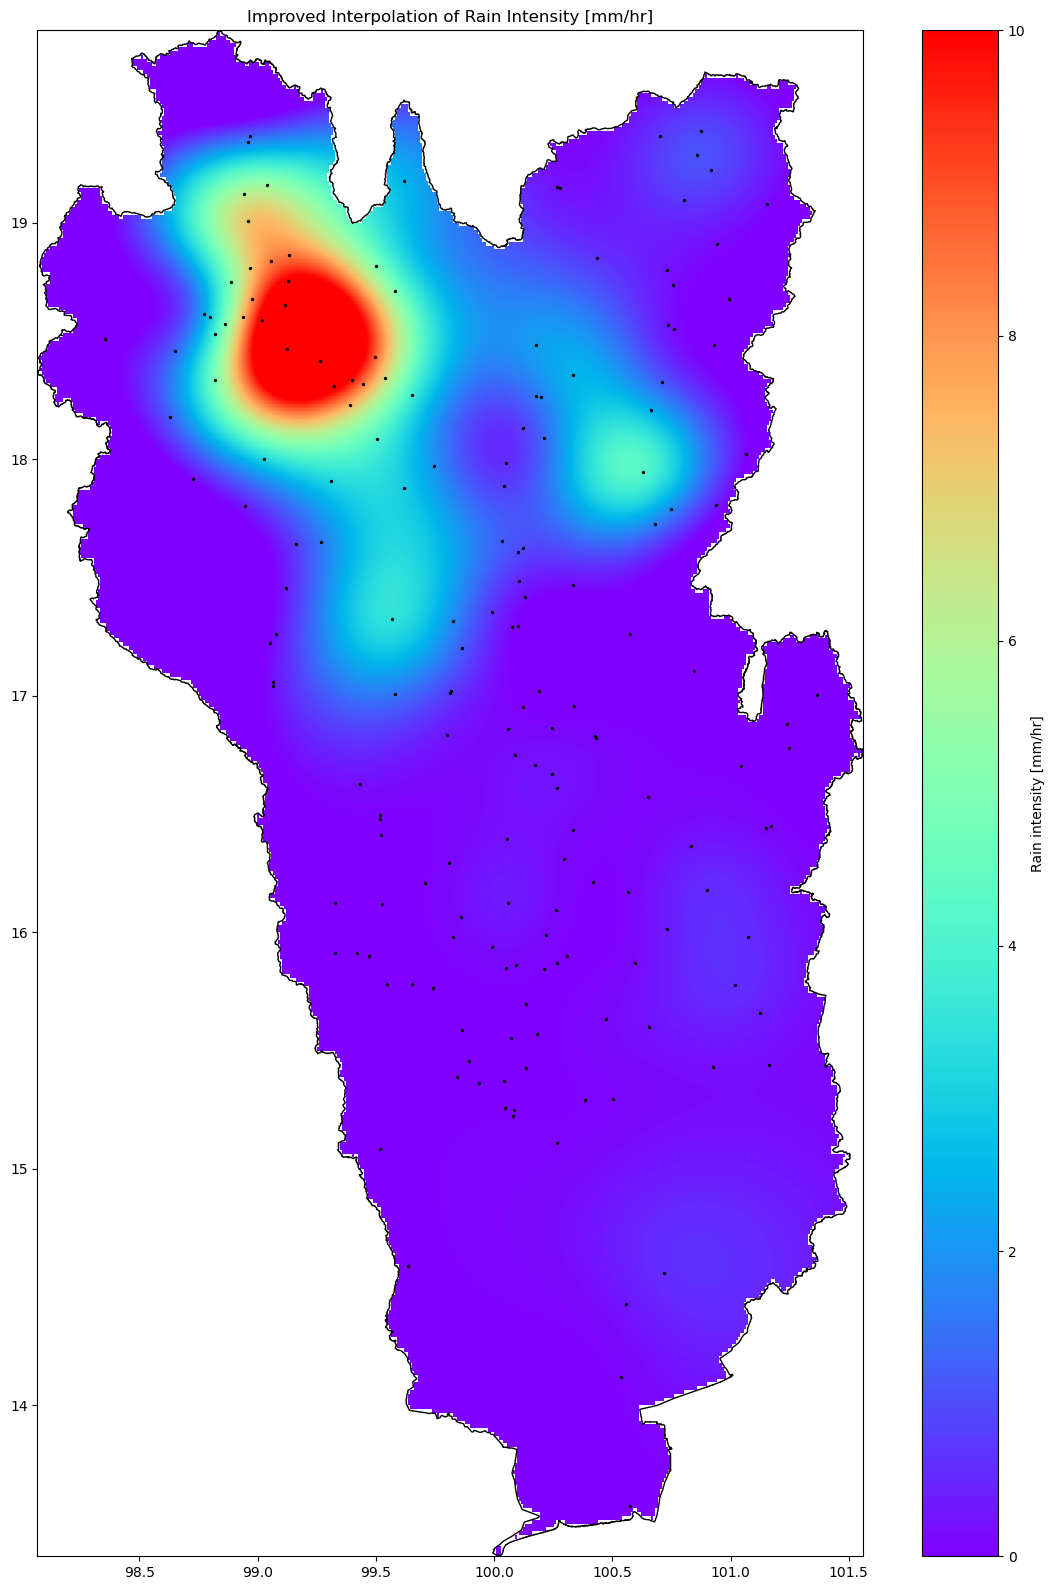

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import Rbf
import rasterio
from rasterio import features

# Read the data
CPY_bnd = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_Boundary_WGS84Geo.shp')
CPY_bnd.set_crs(epsg=4326, inplace=True)
file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071719.csv'
df = pd.read_csv(file_path)

# Convert the dataframe to a GeoDataFrame
data_rain = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
data_rain.set_crs(epsg=4326, inplace=True)

# Meshgrid for interpolation
xmin, ymin, xmax, ymax = CPY_bnd.total_bounds
nx, ny = 400, 400
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymax, ymin, ny)
xi, yi = np.meshgrid(xi, yi)

# Get x, y, z values from data
x = data_rain.geometry.x
y = data_rain.geometry.y
z = data_rain.rain

# Perform interpolation using Radial Basis Function (RBF)
rbf = Rbf(x, y, z, function='multiquadric', smooth=0.3)
rain_grid = rbf(xi, yi)

# Create a mask for the Chao Phraya basin using rasterio
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, nx, ny)
mask = rasterio.features.geometry_mask([CPY_bnd.geometry.iloc[0]], out_shape=(ny, nx), transform=transform, invert=True)

# Apply the mask to the interpolated data
rain_grid_masked = np.where(mask, rain_grid, np.nan)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 16))

# Show the rain grid
im = ax.imshow(rain_grid_masked, extent=(xmin, xmax, ymin, ymax), 
               origin='upper', cmap='rainbow', vmin=0, vmax=10)

# Overlay the stations
ax.scatter(data_rain.geometry.x, data_rain.geometry.y, color="black", s=2)

# Add the CPY_bnd boundary
CPY_bnd.boundary.plot(ax=ax, color="black", linewidth=1)

# Add colorbar and title
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Rain intensity [mm/hr]")
plt.title("Improved Interpolation of Rain Intensity [mm/hr]")

# Adjust the aspect ratio to match the geographic coordinates
ax.set_aspect('equal')

# Set the correct y-axis direction
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

* ดูการประมาณค่า จากแผนที่จุดฝน ทำให้เห็นว่าสอดคล้องกันค่อนข้างมาก แต่ต้องเล่นกับพารามิเตอร์ของ RBF แล้วต้องลอง IDW อย่างง่ายด้วย

# เปรียบเทียบ ผล RBF กับ IDW

C:\Users\Admin\AppData\Local\Temp\ipykernel_19496\428915810.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])


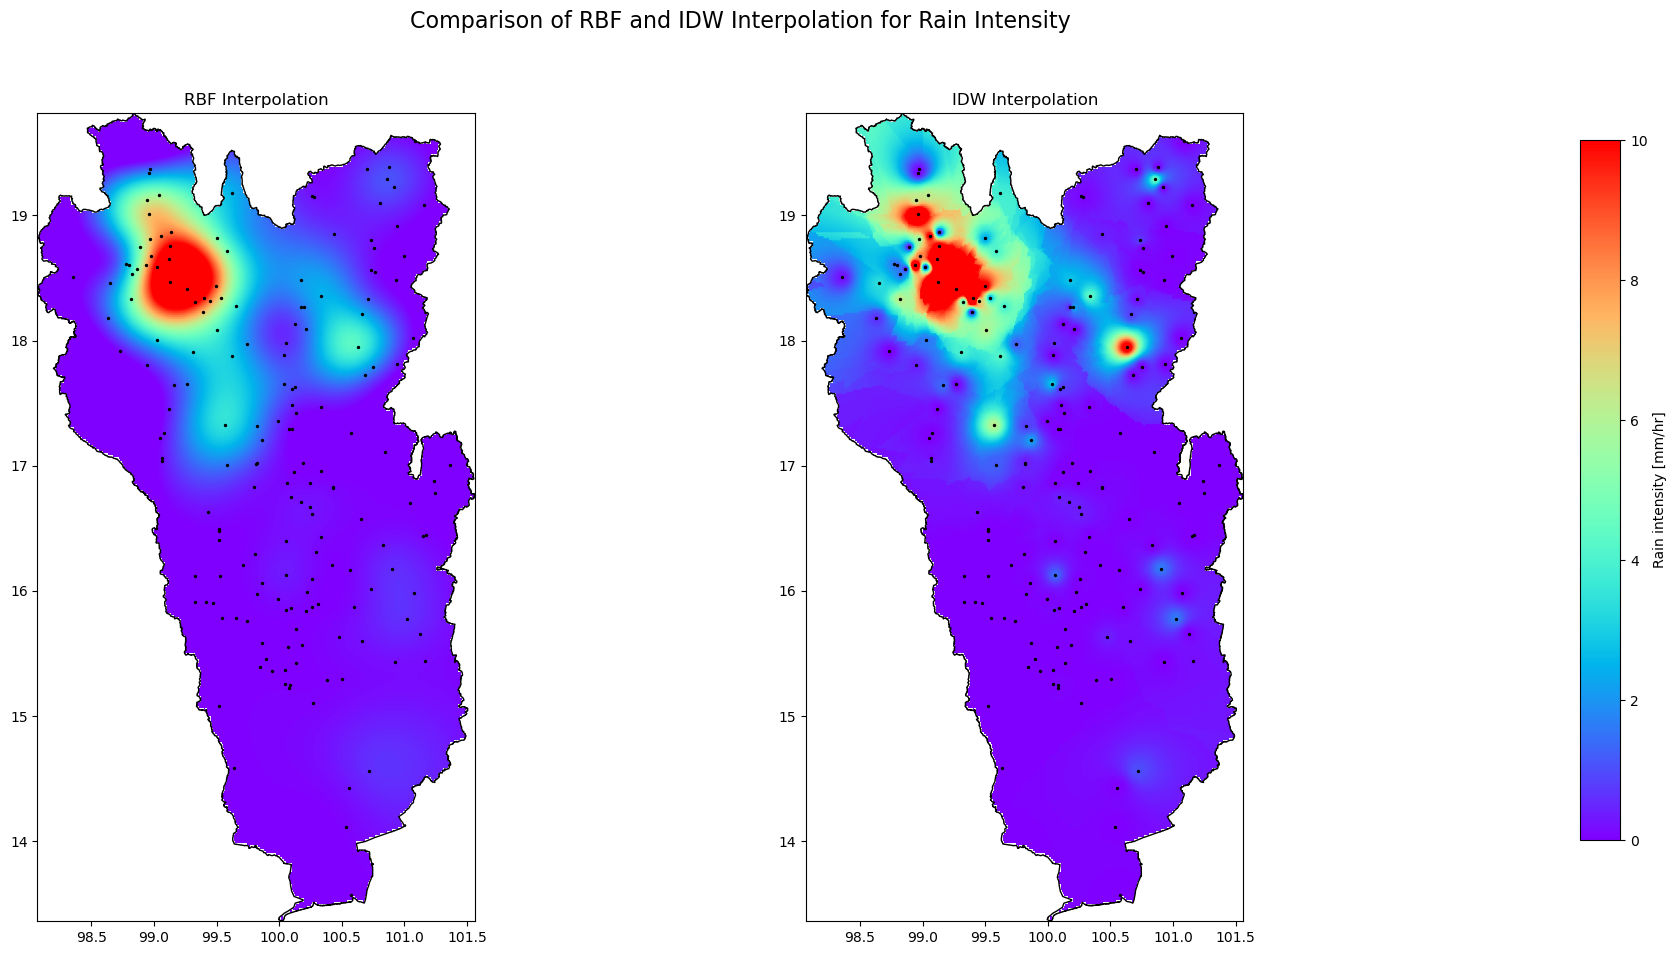

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import cKDTree
import rasterio
from rasterio import features

# Read the data
CPY_bnd = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_Boundary_WGS84Geo.shp')
CPY_bnd.set_crs(epsg=4326, inplace=True)
file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071719.csv'
df = pd.read_csv(file_path)

# Convert the dataframe to a GeoDataFrame
data_rain = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
data_rain.set_crs(epsg=4326, inplace=True)

# Meshgrid for interpolation
xmin, ymin, xmax, ymax = CPY_bnd.total_bounds
nx, ny = 400, 400
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymax, ymin, ny)
xi, yi = np.meshgrid(xi, yi)

# Get x, y, z values from data
x = data_rain.geometry.x.values
y = data_rain.geometry.y.values
z = data_rain.rain.values

# Custom IDW function
def idw_interpolation(x, y, z, xi, yi, power=2):
    tree = cKDTree(list(zip(x, y)))
    dists, indexes = tree.query(list(zip(xi.ravel(), yi.ravel())), k=10)
    
    weights = 1.0 / (dists**power)
    weights /= weights.sum(axis=1, keepdims=True)
    
    zi = np.sum(z[indexes] * weights, axis=1)
    return zi.reshape(xi.shape)

# Perform RBF interpolation
rbf = Rbf(x, y, z, function='multiquadric', smooth=0.3)
rain_grid_rbf = rbf(xi, yi)

# Perform IDW interpolation
rain_grid_idw = idw_interpolation(x, y, z, xi, yi, power=2)

# Create a mask for the Chao Phraya basin using rasterio
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, nx, ny)
mask = rasterio.features.geometry_mask([CPY_bnd.geometry.iloc[0]], out_shape=(ny, nx), transform=transform, invert=True)

# Apply the mask to both interpolated data
rain_grid_rbf_masked = np.where(mask, rain_grid_rbf, np.nan)
rain_grid_idw_masked = np.where(mask, rain_grid_idw, np.nan)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# RBF plot
im1 = ax1.imshow(rain_grid_rbf_masked, extent=(xmin, xmax, ymin, ymax), 
                 origin='upper', cmap='rainbow', vmin=0, vmax=10)
ax1.scatter(x, y, color="black", s=2)
CPY_bnd.boundary.plot(ax=ax1, color="black", linewidth=1)
ax1.set_title("RBF Interpolation")
ax1.set_aspect('equal')
ax1.set_ylim(ymin, ymax)

# IDW plot
im2 = ax2.imshow(rain_grid_idw_masked, extent=(xmin, xmax, ymin, ymax), 
                 origin='upper', cmap='rainbow', vmin=0, vmax=10)
ax2.scatter(x, y, color="black", s=2)
CPY_bnd.boundary.plot(ax=ax2, color="black", linewidth=1)
ax2.set_title("IDW Interpolation")
ax2.set_aspect('equal')
ax2.set_ylim(ymin, ymax)

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Rain intensity [mm/hr]")

plt.suptitle("Comparison of RBF and IDW Interpolation for Rain Intensity", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.show()

* ผลของการประมาณค่า ระหว่าง RBF กับ IDW ออกมา smooth มากขึ้น

# ลอง smooth IDW ใช้จำนวนจุดที่มากขึ้น เล่นกับ power

C:\Users\Admin\AppData\Local\Temp\ipykernel_19496\3260579926.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])


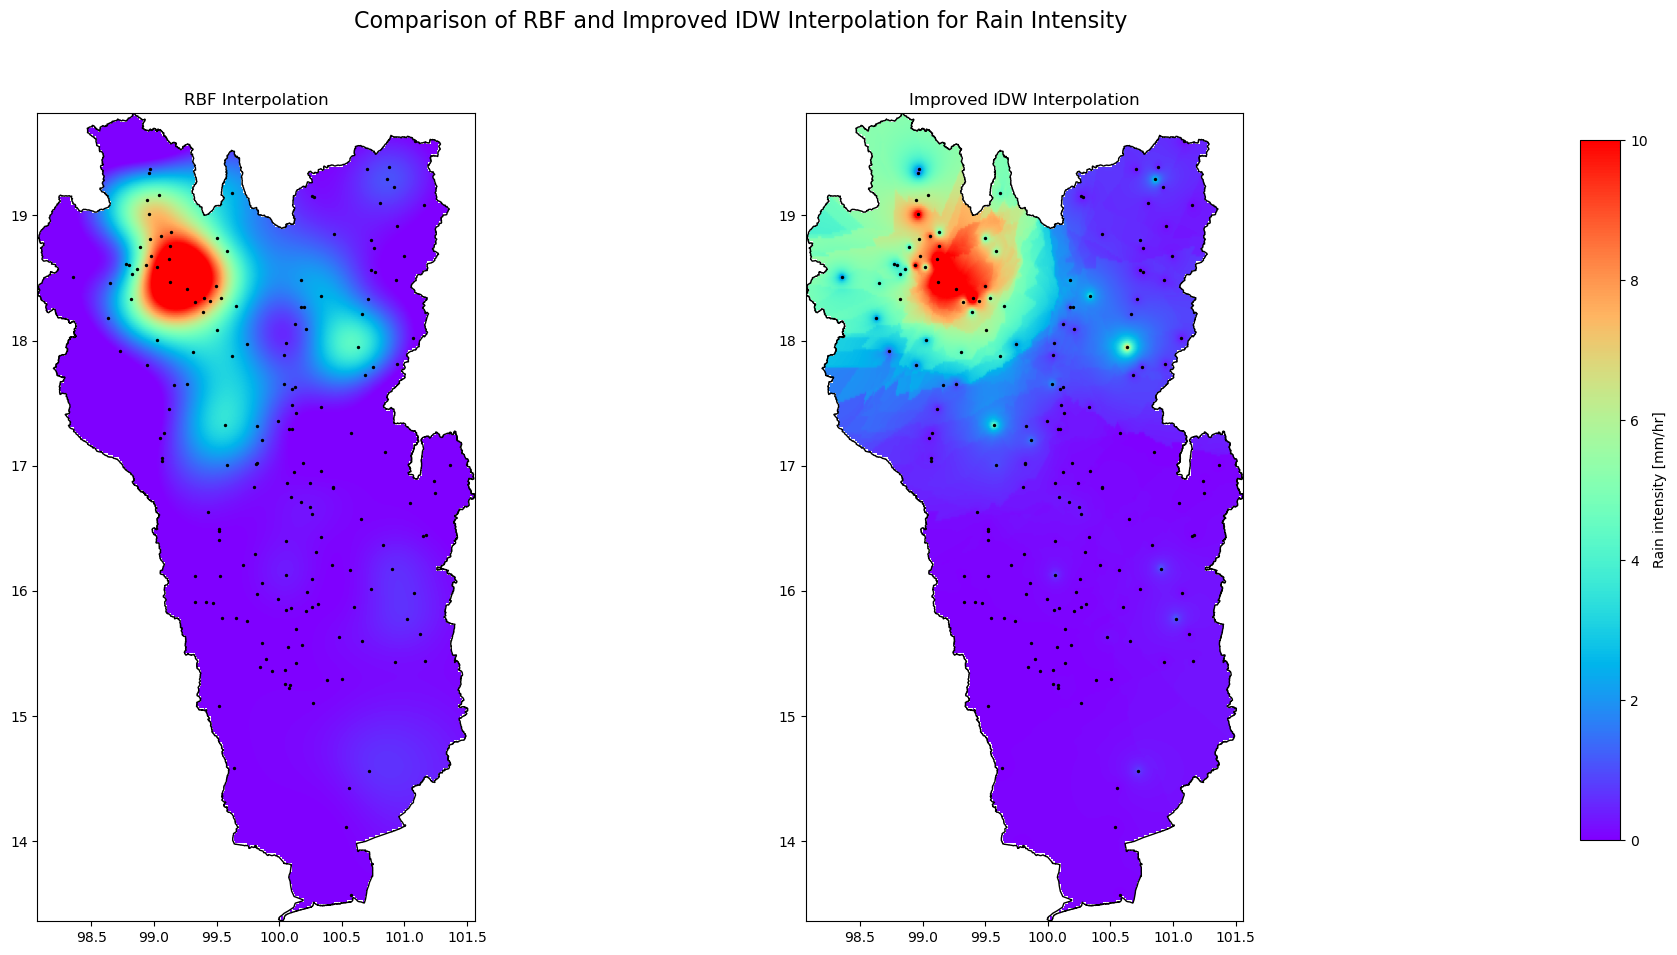

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
import rasterio
from rasterio import features

# Read the data
CPY_bnd = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_Boundary_WGS84Geo.shp')
CPY_bnd.set_crs(epsg=4326, inplace=True)
file_path = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/2018071719.csv'
df = pd.read_csv(file_path)

# Convert the dataframe to a GeoDataFrame
data_rain = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
data_rain.set_crs(epsg=4326, inplace=True)

# Meshgrid for interpolation
xmin, ymin, xmax, ymax = CPY_bnd.total_bounds
nx, ny = 400, 400
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymax, ymin, ny)
xi, yi = np.meshgrid(xi, yi)

# Get x, y, z values from data
x = data_rain.geometry.x.values
y = data_rain.geometry.y.values
z = data_rain.rain.values

# Improved IDW function
def improved_idw_interpolation(x, y, z, xi, yi, power=1, neighbors=20, smoothing=0.5):
    tree = cKDTree(list(zip(x, y)))
    dists, indexes = tree.query(list(zip(xi.ravel(), yi.ravel())), k=neighbors)
    
    weights = 1.0 / (dists**power)
    weights /= weights.sum(axis=1, keepdims=True)
    
    zi = np.sum(z[indexes] * weights, axis=1)
    zi = zi.reshape(xi.shape)
    
    # Apply Gaussian smoothing
    zi_smooth = gaussian_filter(zi, sigma=smoothing)
    
    return zi_smooth

# Perform RBF interpolation
rbf = Rbf(x, y, z, function='multiquadric', smooth=0.3)
rain_grid_rbf = rbf(xi, yi)

# Perform improved IDW interpolation
rain_grid_idw = improved_idw_interpolation(x, y, z, xi, yi, power=1, neighbors=20, smoothing=0.5)

# Create a mask for the Chao Phraya basin using rasterio
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, nx, ny)
mask = rasterio.features.geometry_mask([CPY_bnd.geometry.iloc[0]], out_shape=(ny, nx), transform=transform, invert=True)

# Apply the mask to both interpolated data
rain_grid_rbf_masked = np.where(mask, rain_grid_rbf, np.nan)
rain_grid_idw_masked = np.where(mask, rain_grid_idw, np.nan)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# RBF plot
im1 = ax1.imshow(rain_grid_rbf_masked, extent=(xmin, xmax, ymin, ymax), 
                 origin='upper', cmap='rainbow', vmin=0, vmax=10)
ax1.scatter(x, y, color="black", s=2)
CPY_bnd.boundary.plot(ax=ax1, color="black", linewidth=1)
ax1.set_title("RBF Interpolation")
ax1.set_aspect('equal')
ax1.set_ylim(ymin, ymax)

# IDW plot
im2 = ax2.imshow(rain_grid_idw_masked, extent=(xmin, xmax, ymin, ymax), 
                 origin='upper', cmap='rainbow', vmin=0, vmax=10)
ax2.scatter(x, y, color="black", s=2)
CPY_bnd.boundary.plot(ax=ax2, color="black", linewidth=1)
ax2.set_title("Improved IDW Interpolation")
ax2.set_aspect('equal')
ax2.set_ylim(ymin, ymax)

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Rain intensity [mm/hr]")

plt.suptitle("Comparison of RBF and Improved IDW Interpolation for Rain Intensity", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.show()

* ผล IDW มีความเรียบมากขึ้น เมื่อเล่นกับจำนวนจุด เล่นกับ power และการใส่ตัวกรอง gaussian ลงไป แต่ต้องลองทดสอบกับข้อมูลจริง ๆ มันอาจจะ smooth เกินไปก็ได้